## TOMEK Sampling and Ztest for Baseline and TOMEK -  #700055807

In [1]:
#importing all modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score,fbeta_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [2]:
#importing white wine data set (UCI https://archive.ics.uci.edu/ml/datasets/wine+quality)

wine_df = pd.read_csv('data/winequality-white.csv', sep=';')

data = wine_df.copy()

In [3]:
#Creating the catigorical target, less than 8 as 0 and more than 8 as 1

data['type'] = np.where(data['quality'] < 8, 'bad', 'good')

In [4]:
# using the enconder to code 0,1 for bad and good respectvily 

le = LabelEncoder()
data['target'] = le.fit_transform(data['type'])

In [5]:
data['type'].value_counts(normalize=True)* 100

bad     96.325031
good     3.674969
Name: type, dtype: float64

## Splitting train data for TOMEK

In [6]:
#import TOMEK

from imblearn.under_sampling import TomekLinks
# Separate input features and target
y = data.iloc[:,-1]
X = data.iloc[:,:-3]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

tl = TomekLinks(sampling_strategy='not majority')
X_train, y_train = tl.fit_resample(X_train, y_train)

In [7]:
# running the classifiers for the TOMEK sampling


model_scores = {}
model_roc_scores = {}
model_fbeta_score = {}
precision_scores = {}

DT_re_tl = DecisionTreeClassifier()
log_tl = LogisticRegression()
RF_tl = RandomForestClassifier()

for model in [DT_re_tl, log_tl, RF_tl]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    model_scores[model] = score
    
    y_pred_proba = model.predict_proba(X_test)
    roc = roc_auc_score(y_test, y_pred_proba[:,1])
    model_roc_scores[model] = roc
    
    y_pred_proba = model.predict_proba(X_test)
    fb_score = fbeta_score(y_test, y_pred, beta=0.5)
    model_fbeta_score[model] = fb_score
    
    y_pred = model.predict(X_test)
    p_score = precision_score(y_test, y_pred)
    precision_scores[model] = p_score
    
    
model_scores
model_roc_scores
model_fbeta_score
precision_scores

roc_df = pd.DataFrame(list(model_roc_scores.items()),columns = ['Model','Roc Auc Score']) 
scores_df = pd.DataFrame(list(model_scores.items()),columns = ['Model1','Accuracy Score'])
precision_scores_df = pd.DataFrame(list(precision_scores.items()), columns=['Model3','Precision Score'])
fbeta_scores_df = pd.DataFrame(list(model_fbeta_score.items()), columns=['Model2','F_beta Score'])

total_scores_df = pd.concat([roc_df,scores_df ,precision_scores_df, fbeta_scores_df], axis=1)
total_scores_df.drop(['Model1', 'Model2', 'Model3'], axis=1, inplace=True)
total_scores_df.index.name = 'TOMEK Sampling'
total_scores_df = total_scores_df.round(2)
total_scores_df.index = ['DecisionTreeClassifier', 'LogisticRegression', 'RandomForestClassifier']
total_scores_df

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,DecisionTreeClassifier(),0.65,0.96,0.57,0.49
LogisticRegression,LogisticRegression(),0.73,0.96,0.00,0.00
RandomForestClassifier,"(DecisionTreeClassifier(max_features='auto', r...",0.87,0.97,0.93,0.64


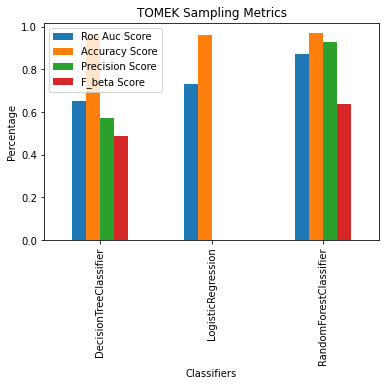

In [8]:
#plotting the comparison - TOMEK sampling

total_scores_df.plot(kind='bar')
plt.title('TOMEK Sampling Metrics')
plt.ylabel('Percentage')
plt.xlabel('Classifiers')
plt.show()

In [9]:
#Final df for comparison
total_scores_df.drop('Model', axis=1)

,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,0.65,0.96,0.57,0.49
LogisticRegression,0.73,0.96,0.00,0.00
RandomForestClassifier,0.87,0.97,0.93,0.64


## Running the classifiers for DT, RF, Log - TOMEK Sampling


In [10]:
log_tl = LogisticRegression(solver='liblinear')
log_tl.fit(X_train, y_train)
y_pred_log_tl = log_tl.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred_log_tl)

0.9591836734693877

No Skill: ROC AUC=0.500
Logistic TOMEK: ROC AUC=0.721


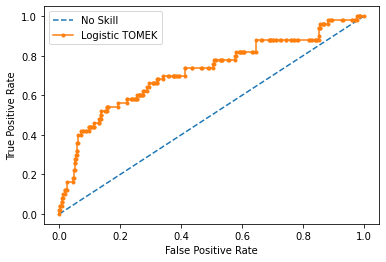

In [12]:
#AUC for logistic

ns_probs = [0 for _ in range(len(y_test))]
y_pred_log_tl_proba = log_tl.predict_proba(X_test)
log_tl_probs = y_pred_log_tl_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
log_tl_auc = roc_auc_score(y_test, log_tl_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic TOMEK: ROC AUC=%.3f' % (log_tl_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logtl_fpr, logtl_tpr, _ = roc_curve(y_test, log_tl_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(logtl_fpr, logtl_tpr, marker='.', label='Logistic TOMEK')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [9]:
print(classification_report(y_test, y_pred_log_tl))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1175
           1       0.00      0.00      0.00        50

    accuracy                           0.96      1225
   macro avg       0.48      0.50      0.49      1225
weighted avg       0.92      0.96      0.94      1225



/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
DT_re_tl = DecisionTreeClassifier()
DT_re_tl.fit(X_train, y_train)
y_pred_DT_tl = DT_re_tl.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred_DT_tl)

0.9583673469387755

In [12]:
print(classification_report(y_test, y_pred_DT_tl))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1175
           1       0.49      0.36      0.41        50

    accuracy                           0.96      1225
   macro avg       0.73      0.67      0.70      1225
weighted avg       0.95      0.96      0.96      1225



No Skill: ROC AUC=0.500
DT TOMEK: ROC AUC=0.672


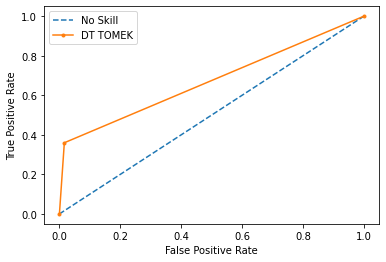

In [38]:
#AUC for DT

ns_probs = [0 for _ in range(len(y_test))]
y_pred_DT_re_tl_proba = DT_re_tl.predict_proba(X_test)
DT_re_tl_probs = y_pred_DT_re_tl_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
DT_re_tl_auc = roc_auc_score(y_test, DT_re_tl_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DT TOMEK: ROC AUC=%.3f' % (DT_re_tl_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
DTtl_fpr, DTtl_tpr, _ = roc_curve(y_test, DT_re_tl_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(DTtl_fpr, DTtl_tpr, marker='.', label='DT TOMEK')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [13]:
RF_tl = RandomForestClassifier()
RF_tl.fit(X_train, y_train)
y_pred_RF_tl = RF_tl.predict(X_test)
accuracy_score(y_test, y_pred_RF_tl)

0.9697959183673469

In [14]:
print(classification_report(y_test, y_pred_RF_tl))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1175
           1       0.93      0.28      0.43        50

    accuracy                           0.97      1225
   macro avg       0.95      0.64      0.71      1225
weighted avg       0.97      0.97      0.96      1225



No Skill: ROC AUC=0.500
RF TOMEK: ROC AUC=0.866


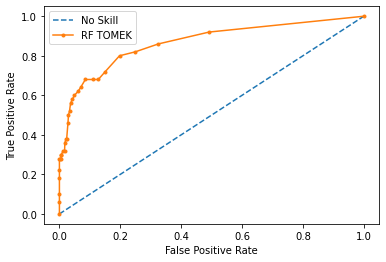

In [39]:
#AUC for RF

ns_probs = [0 for _ in range(len(y_test))]
y_pred_RF_tl_proba = RF_tl.predict_proba(X_test)
RF_tl_probs = y_pred_RF_tl_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
RF_tl_auc = roc_auc_score(y_test, RF_tl_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF TOMEK: ROC AUC=%.3f' % (RF_tl_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
RFtl_fpr, RFtl_tpr, _ = roc_curve(y_test, RF_tl_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(RFtl_fpr, RFtl_tpr, marker='.', label='RF TOMEK')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Finding the best theshold test

Best Threshold=0.130000, F-Score=0.463


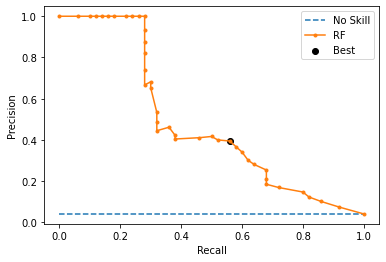

In [59]:
#how to get best threshold, testing on RF only

y_pred_RF_tl_proba = RF_tl.predict_proba(X_test)
RF_tl_probs = y_pred_RF_tl_proba[:,1]
y_pred_RF_tl = RF_tl.predict(X_test)

RF_precision, RF_recall, thre = precision_recall_curve(y_test, RF_tl_probs)


fscore = (2 * RF_precision * RF_recall) / (RF_precision + RF_recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thre[ix], fscore[ix]))


RF_f1, RF_auc = f1_score(y_test, y_pred_RF_tl), auc(RF_recall, RF_precision)

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(RF_recall, RF_precision, marker='.', label='RF')
plt.scatter(RF_recall[ix], RF_precision[ix], marker='o', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()




In [52]:
#view best threshold in confusion matrix

for thre in np.arange(0,1,0.1):
    y = y_pred_RF_tl_proba[:,1] > thre
    print('this is a threshold of: '+ str(thre))
    print(confusion_matrix(y_test, y))

this is a threshold of: 0.0
[[597 578]
 [  4  46]]
this is a threshold of: 0.1
[[1117   58]
 [  20   30]]
this is a threshold of: 0.2
[[1158   17]
 [  34   16]]
this is a threshold of: 0.30000000000000004
[[1170    5]
 [  36   14]]
this is a threshold of: 0.4
[[1173    2]
 [  36   14]]
this is a threshold of: 0.5
[[1174    1]
 [  36   14]]
this is a threshold of: 0.6000000000000001
[[1175    0]
 [  36   14]]
this is a threshold of: 0.7000000000000001
[[1175    0]
 [  43    7]]
this is a threshold of: 0.8
[[1175    0]
 [  44    6]]
this is a threshold of: 0.9
[[1175    0]
 [  44    6]]


No Skill: ROC AUC=0.500
Logistic TOMEK: ROC AUC=0.721


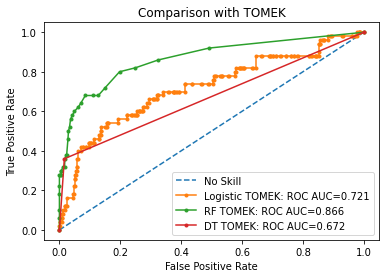

In [72]:
#all AUC

ns_probs = [0 for _ in range(len(y_test))]
y_pred_log_tl_proba = log_tl.predict_proba(X_test)
log_tl_probs = y_pred_log_tl_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
log_tl_auc = roc_auc_score(y_test, log_tl_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic TOMEK: ROC AUC=%.3f' % (log_tl_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logtl_fpr, logtl_tpr, _ = roc_curve(y_test, log_tl_probs)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(logtl_fpr, logtl_tpr, marker='.', label='Logistic TOMEK: ROC AUC=%.3f' % (log_tl_auc))
plt.plot(RFtl_fpr, RFtl_tpr, marker='.', label='RF TOMEK: ROC AUC=%.3f' % (RF_tl_auc))
plt.plot(DTtl_fpr, DTtl_tpr, marker='.', label='DT TOMEK: ROC AUC=%.3f' % (DT_re_tl_auc))



# axis labels
plt.title('Comparison with TOMEK')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Z-test for TOMEK and Baseline for Random Forest only

In [13]:
#running TOMEK classifier 100x

RF_tomek_list = []

for i in range(0,100):

    RF_tl = RandomForestClassifier()
    RF_tl.fit(X_train, y_train)
    #y_pred_RF_tl = RF_tl.predict(X_test)
    #accuracy_score(y_test, y_pred_RF_tl)
    #ns_probs = [0 for _ in range(len(y_test))]
    y_pred_RF_tl_proba = RF_tl.predict_proba(X_test)
    RF_tl_probs = y_pred_RF_tl_proba[:,1]
    #ns_auc = roc_auc_score(y_test, ns_probs)
    RF_tl_auc = roc_auc_score(y_test, RF_tl_probs)
    #print(RF_tl_auc)
    RF_tomek_list.append(RF_tl_auc)
    


In [15]:
#Train and Test for RF with no sampling methods
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X, y, random_state=27)


In [16]:
#running baseline classifier 100x

RF_normal_list = []


for i in range(0,100):

    RF_n = RandomForestClassifier()
    RF_n.fit(X_train_n, y_train_n)
    #y_pred_RF_tl = RF_tl.predict(X_test)
    #accuracy_score(y_test, y_pred_RF_tl)
    #ns_probs = [0 for _ in range(len(y_test))]
    y_pred_RF_tl_proba = RF_n.predict_proba(X_test_n)
    RF_tl_probs = y_pred_RF_tl_proba[:,1]
    #ns_auc = roc_auc_score(y_test, ns_probs)
    RF_tl_auc = roc_auc_score(y_test, RF_tl_probs)
    #print(RF_tl_auc)
    RF_normal_list.append(RF_tl_auc)
    

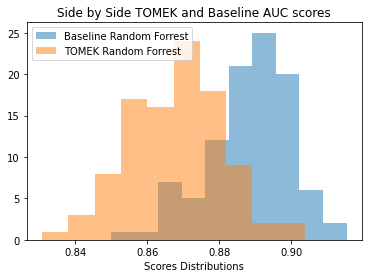

In [18]:
# Side by Side TOMEK and Baseline AUC scores
plt.title('Side by Side TOMEK and Baseline AUC scores')
plt.hist(RF_normal_list, alpha=0.5, label='Baseline Random Forrest')
plt.hist(RF_tomek_list,alpha=0.5, label='TOMEK Random Forrest')
plt.xlabel('Scores Distributions')
plt.legend()
plt.show()


In [19]:
#concat both results into df
Normal_df_RF = pd.DataFrame(RF_normal_list, columns=['Normal_RF'])
TOMEK_df_RF = pd.DataFrame(RF_tomek_list, columns=['TOMEK_RF'])
ztest_df_combo = pd.concat([Normal_df_RF, TOMEK_df_RF], axis=1)
ztest_df_combo

,Normal_RF,TOMEK_RF
0,0.896077,0.861336
1,0.882987,0.867643
2,0.890230,0.856281
3,0.871379,0.870068
4,0.874051,0.860791
...,...,...
95,0.896528,0.846238
96,0.884136,0.873191
97,0.895021,0.887702
98,0.864196,0.891268


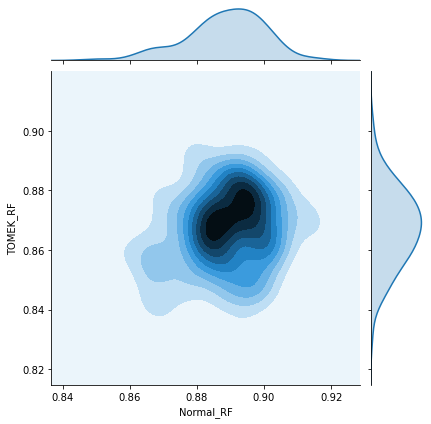

In [20]:
#joint plot of TOMEK and Baseline
sns.jointplot(x=ztest_df_combo['Normal_RF'], y=ztest_df_combo['TOMEK_RF'], data=ztest_df_combo, kind='kde');

In [22]:
#pip install statsmodels
#z test for TOMEK and baseline
from scipy import stats
from statsmodels.stats import weightstats as stests
ztest ,pval = stests.ztest(ztest_df_combo['Normal_RF'],ztest_df_combo['TOMEK_RF'] )
print(float(pval))
print(ztest)

1.381608461507394e-32
11.887074965029937
